### Stock Prices and Google Trends Heatmap Analysis
### This notebook creates visualizations for stock price movements and Google search trends data.
### Required Data Files:
#### - `prices.csv`: Stock/ETF daily closing prices (columns = stocks, rows = dates)
#### - `trends.csv`: Google search trends data (columns = search terms, rows = dates)

In [55]:
# Import Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [56]:
# Set the style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


### Helper Functions

In [57]:
def load_and_process_data(filepath, data_type='prices'):
    """
    Load CSV data and process it for heatmap visualization
    """
    try:
        # Load the data
        df = pd.read_csv(filepath, index_col=0, parse_dates=True)
        print(f"Loaded {data_type} data: {df.shape[0]} dates, {df.shape[1]} columns")

        # Handle any missing values
        if df.isnull().sum().sum() > 0:
            print(f"Warning: Found {df.isnull().sum().sum()} missing values in {data_type} data")
            df = df.fillna(method='ffill').fillna(method='bfill')

        return df
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None

In [58]:
def normalize_prices(df_prices):
    """
    Normalize prices to percentage change from first value for better visualization
    """
    # Calculate percentage change from first valid value for each stock
    df_normalized = pd.DataFrame(index=df_prices.index, columns=df_prices.columns)

    for col in df_prices.columns:
        first_valid = df_prices[col].first_valid_index()
        if first_valid is not None:
            first_value = df_prices.loc[first_valid, col]
            if first_value != 0:
                df_normalized[col] = ((df_prices[col] / first_value) - 1) * 100
            else:
                df_normalized[col] = 0

    return df_normalized

In [59]:
def create_heatmap(data, title, ax, cmap='RdYlGn', center=None, fmt='.1f',
                    vmin=None, vmax=None, cbar_label='Value'):
    """
    Create a heatmap with customizable parameters
    """
    # Transpose data so columns (stocks/trends) are on y-axis and dates on x-axis
    data_transposed = data.T

    # Create the heatmap
    sns.heatmap(data_transposed,
                cmap=cmap,
                center=center,
                ax=ax,
                cbar_kws={'label': cbar_label},
                xticklabels=False,  # We'll customize x-labels
                yticklabels=True,
                vmin=vmin,
                vmax=vmax)

    # Set title
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)

    # Customize x-axis to show dates at regular intervals
    n_dates = len(data.index)
    if n_dates > 20:
        # Show approximately 10 date labels
        step = n_dates // 10
        positions = range(0, n_dates, step)
        labels = [data.index[i].strftime('%Y-%m-%d') if hasattr(data.index[i], 'strftime')
                    else str(data.index[i]) for i in positions]
        ax.set_xticks(positions)
        ax.set_xticklabels(labels, rotation=45, ha='right')
    else:
        # Show all dates if not too many
        labels = [date.strftime('%Y-%m-%d') if hasattr(date, 'strftime')
                    else str(date) for date in data.index]
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=45, ha='right')

    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Stocks/Trends', fontsize=12)

    # Adjust y-axis labels if too many
    if len(data.columns) > 30:
        # Show every nth label
        n = max(1, len(data.columns) // 30)
        for i, label in enumerate(ax.yaxis.get_ticklabels()):
            if i % n != 0:
                label.set_visible(False)

### Load and Explore Data

In [60]:
DATA_ROOT = Path("../../data")

PROCESSED_DATA = DATA_ROOT / "processed"

# File paths
prices_file = PROCESSED_DATA / 'prices.csv'
trends_file = PROCESSED_DATA / 'trends.csv'

In [62]:
PLOT_ROOT = Path("../../plots/heatmaps")
PLOT_ROOT.mkdir(parents=True, exist_ok=True)
print(f"Plot directory set to: {PLOT_ROOT}")

Plot directory set to: ../../plots/heatmaps


In [63]:
print("Loading data files...")
print("-" * 50)

df_prices = load_and_process_data(prices_file, 'prices')
df_trends = load_and_process_data(trends_file, 'trends')

Loading data files...
--------------------------------------------------
Loaded prices data: 1781 dates, 92 columns
Loaded trends data: 1781 dates, 1870 columns


In [64]:
# Display basic information about the data
if df_prices is not None:
    print("\nPRICES DATA SUMMARY:")
    print("-" * 30)
    print(f"Date range: {df_prices.index[0]} to {df_prices.index[-1]}")
    print(f"Number of stocks/ETFs: {len(df_prices.columns)}")
    print(f"Sample stocks: {list(df_prices.columns[:5])}")
    print("\nFirst few rows:")
    display(df_prices.head())

    print("\nBasic statistics:")
    display(df_prices.describe())


PRICES DATA SUMMARY:
------------------------------
Date range: 2020-09-05 00:00:00 to 2025-07-27 00:00:00
Number of stocks/ETFs: 92
Sample stocks: ['ISRG', 'RSX', 'US_Transportation', 'Russell2000', 'US_Biotech']

First few rows:


ISRG        RSX  US_Transportation  Russell2000  US_Biotech  \
date                                                                            
2020-09-05  241.667503  17.621191          46.892964   142.894089  127.062748   
2020-09-06  238.241669  17.459900          46.749323   142.203415  126.470291   
2020-09-07  234.815834  17.298609          46.605681   141.512741  125.877834   
2020-09-12  235.713328  17.570119          47.468519   141.385880  128.461624   
2020-09-13  237.246663  17.631948          47.623789   142.616882  130.739296   

               Google           V  US_Consumer_Staples  \
date                                                     
2020-09-05  77.873346  196.369957            57.199994   
2020-09-06  77.157513  195.274857            56.897303   
2020-09-07  76.441679  194.179756            56.594611   
2020-09-12  75.221369  195.007914            56.844652   
2020-09-13  75.106557  196.390859            56.967482   

            US_Consumer_Discretionary        BAC  ...          MA        SLB  \
date                                              ...                          
2020-09-05                 140.857487  23.391249  ...  324.460999  17.305879   
2020-09-06                 140.394127  23.155334  ...  323.214111  17.094971   
2020-09-07                 139.930767  22.919418  ...  321.967224  16.884063   
2020-09-12                 140.770223  22.775499  ...  323.721293  16.258895   
2020-09-13                 141.266383  22.849686  ...  326.459768  16.307273   

                  AAPL  HydrogenCCS         SAP        ASML         JNJ  \
date                                                                      
2020-09-05  115.680460    93.983095  145.613503  348.347137  128.549974   
2020-09-06  113.700985    93.692645  144.523102  343.524231  128.261677   
2020-09-07  111.721510    93.402194  143.432701  338.701324  127.973379   
2020-09-12  110.033844    94.146489  147.179342  348.088420  128.300705   
2020-09-13  111.123276    94.971942  147.525935  350.879140  128.465469   

                   CRM  CleanWater         BLK  
date                                            
2020-09-05  249.159214   97.967183  500.385529  
2020-09-06  245.830879   97.573967  497.692505  
2020-09-07  242.502544   97.180750  494.999481  
2020-09-12  242.158086   99.294420  484.038066  
2020-09-13  243.327830   99.537421  485.873494  

[5 rows x 92 columns]


Basic statistics:


ISRG          RSX  US_Transportation  Russell2000   US_Biotech  \
count  1781.000000  1781.000000        1781.000000  1781.000000  1781.000000   
mean    340.745427    10.335801          60.517940   194.098741   136.120925   
std     107.321222     7.782984           6.227150    20.810827    13.815441   
min     183.059998     4.983042          45.872871   135.897263   104.920464   
25%     257.980011     4.983042          55.370064   177.718735   126.569962   
50%     309.153320     5.618700          61.148998   196.216171   133.719513   
75%     397.630005    19.177666          65.127838   211.121755   145.254257   
max     610.450012    27.772713          74.781403   240.476379   174.332703   

            Google            V  US_Consumer_Staples  \
count  1781.000000  1781.000000          1781.000000   
mean    131.795585   242.441479            69.526279   
std      30.563282    47.579031             6.805926   
min      70.049385   173.635742            54.941357   
25%     106.948593   206.950516            64.642990   
50%     131.882385   225.114777            69.063522   
75%     154.349813   270.291046            73.918190   
max     205.893341   372.654297            82.592926   

       US_Consumer_Discretionary          BAC  ...           MA          SLB  \
count                1781.000000  1781.000000  ...  1781.000000  1781.000000   
mean                  171.769127    34.790835  ...   399.397963    38.544810   
std                    24.831070     6.510877  ...    77.338103    10.646192   
min                   123.540680    20.707155  ...   278.809357    12.863181   
25%                   151.795258    29.649536  ...   342.065735    30.618393   
50%                   170.840942    34.597416  ...   368.582123    39.652683   
75%                   183.642807    39.563389  ...   453.693115    46.925855   
max                   237.815460    48.930000  ...   589.941772    59.365982   

              AAPL  HydrogenCCS          SAP         ASML          JNJ  \
count  1781.000000  1781.000000  1781.000000  1781.000000  1781.000000   
mean    169.183573   137.997940   154.672048   670.122724   149.311245   
std      35.805803    28.787792    59.962951   150.874176     8.656453   
min     103.925171    88.344086    76.173027   338.701324   118.884285   
25%     141.957947   115.749112   113.292274   577.027832   143.971222   
50%     167.087006   138.809442   131.856781   666.905945   150.045761   
75%     191.796188   152.405541   187.911575   750.792887   154.676849   
max     258.103729   273.689432   311.929993  1089.305176   168.324478   

               CRM   CleanWater          BLK  
count  1781.000000  1781.000000  1781.000000  
mean    233.878541   125.412962   746.591173  
std      49.804153    11.079843   139.282359  
min     127.155785    97.180750   476.723053  
25%     202.138748   117.283045   637.990601  
50%     235.885941   125.308642   727.841858  
75%     267.835541   132.839488   830.065125  
max     366.293427   151.938452  1123.280029  

[8 rows x 92 columns]

In [65]:
if df_trends is not None:
    print("\nTRENDS DATA SUMMARY:")
    print("-" * 30)
    print(f"Date range: {df_trends.index[0]} to {df_trends.index[-1]}")
    print(f"Number of search terms: {len(df_trends.columns)}")
    print(f"Sample search terms: {list(df_trends.columns[:5])}")
    print("\nFirst few rows:")
    display(df_trends.head())

    print("\nBasic statistics:")
    display(df_trends.describe())


TRENDS DATA SUMMARY:
------------------------------
Date range: 2020-09-05 00:00:00 to 2025-07-27 00:00:00
Number of search terms: 1870
Sample search terms: ['fintech trends', 'Ethiopia', 'Airbnb news', 'renewable energy stocks', 'Dyson Vacuum vs competitor']

First few rows:


fintech trends   Ethiopia  Airbnb news  renewable energy stocks  \
date                                                                          
2020-09-05        9.142857  51.857143    27.000000                10.285714   
2020-09-06        9.000000  52.000000    27.000000                10.000000   
2020-09-07        9.428571  52.000000    26.857143                10.428571   
2020-09-12       11.571429  52.000000    26.142857                12.571429   
2020-09-13       12.000000  52.000000    26.000000                13.000000   

            Dyson Vacuum vs competitor  SolarEdge news  Eli Lilly stock price  \
date                                                                            
2020-09-05                         0.0             2.0               7.142857   
2020-09-06                         0.0             0.0               7.000000   
2020-09-07                         0.0             0.0               7.571429   
2020-09-12                         0.0             0.0              10.428571   
2020-09-13                         0.0             0.0              11.000000   

            war in Syria  Atlassian       ISRG  ...  probiotics  \
date                                            ...               
2020-09-05      8.857143  41.857143  23.571429  ...   58.142857   
2020-09-06      9.000000  41.000000  22.000000  ...   58.000000   
2020-09-07      9.142857  41.428571  22.428571  ...   58.428571   
2020-09-12      9.857143  43.571429  24.571429  ...   60.571429   
2020-09-13     10.000000  44.000000  25.000000  ...   61.000000   

            Lululemon earnings report  Benjamin Netanyahu  \
date                                                        
2020-09-05                        0.0            3.000000   
2020-09-06                        0.0            3.000000   
2020-09-07                        0.0            3.428571   
2020-09-12                        0.0            5.571429   
2020-09-13                        0.0            6.000000   

            youth climate movement  Mitch McConnell on green bonds  \
date                                                                 
2020-09-05                     0.0                             0.0   
2020-09-06                     0.0                             0.0   
2020-09-07                     0.0                             0.0   
2020-09-12                     0.0                             0.0   
2020-09-13                     0.0                             0.0   

            Meta Quest 3 sales in Jerusalem        BLK  \
date                                                     
2020-09-05                              0.0  85.142857   
2020-09-06                              0.0  85.000000   
2020-09-07                              0.0  85.142857   
2020-09-12                              0.0  85.857143   
2020-09-13                              0.0  86.000000   

            Teva Pharmaceutical news  Apple response to NATO  \
date                                                           
2020-09-05                       0.0                     0.0   
2020-09-06                       0.0                     0.0   
2020-09-07                       0.0                     0.0   
2020-09-12                       0.0                     0.0   
2020-09-13                       0.0                     0.0   

            air quality controversy  
date                                 
2020-09-05                      0.0  
2020-09-06                      0.0  
2020-09-07                      0.0  
2020-09-12                      0.0  
2020-09-13                      0.0  

[5 rows x 1870 columns]


Basic statistics:


fintech trends     Ethiopia  Airbnb news  renewable energy stocks  \
count     1781.000000  1781.000000  1781.000000              1781.000000   
mean        13.403946    63.410925    25.083099                18.910323   
std         11.353152     6.568829     6.075305                13.136916   
min          0.000000    48.000000    13.000000                 5.000000   
25%          9.571429    59.571429    21.142857                10.142857   
50%         11.428571    62.571429    24.714286                15.714286   
75%         14.285714    65.857143    27.428571                22.571429   
max        100.000000   100.000000   100.000000               100.000000   

       Dyson Vacuum vs competitor  SolarEdge news  Eli Lilly stock price  \
count                 1781.000000     1781.000000            1781.000000   
mean                     0.738911        5.028636              30.767466   
std                      6.815295        8.052191              22.179953   
min                      0.000000        0.000000               6.000000   
25%                      0.000000        0.000000              12.000000   
50%                      0.000000        0.000000              19.000000   
75%                      0.000000        8.571429              50.142857   
max                    100.000000      100.000000             100.000000   

       war in Syria    Atlassian         ISRG  ...   probiotics  \
count   1781.000000  1781.000000  1781.000000  ...  1781.000000   
mean      11.069463    48.276811    27.351729  ...    69.561883   
std        7.409120    13.429581    10.035238  ...    10.322423   
min        5.000000    17.000000    13.000000  ...    49.000000   
25%        7.857143    35.428571    20.285714  ...    61.857143   
50%        9.714286    50.142857    24.857143  ...    68.428571   
75%       11.428571    56.285714    32.285714  ...    75.428571   
max      100.000000   100.000000   100.000000  ...   100.000000   

       Lululemon earnings report  Benjamin Netanyahu  youth climate movement  \
count                1781.000000         1781.000000             1781.000000   
mean                    0.594048           10.784551                0.679955   
std                     5.234934           14.205295                6.335288   
min                     0.000000            1.000000                0.000000   
25%                     0.000000            2.000000                0.000000   
50%                     0.000000            4.428571                0.000000   
75%                     0.000000           13.285714                0.000000   
max                   100.000000          100.000000              100.000000   

       Mitch McConnell on green bonds  Meta Quest 3 sales in Jerusalem  \
count                     1781.000000                      1781.000000   
mean                         0.731050                         0.746771   
std                          6.748195                         6.883271   
min                          0.000000                         0.000000   
25%                          0.000000                         0.000000   
50%                          0.000000                         0.000000   
75%                          0.000000                         0.000000   
max                        100.000000                       100.000000   

               BLK  Teva Pharmaceutical news  Apple response to NATO  \
count  1781.000000               1781.000000             1781.000000   
mean     85.503890                  1.167322                0.707468   
std       4.161126                  8.747286                6.552419   
min      74.000000                  0.000000                0.000000   
25%      82.714286                  0.000000                0.000000   
50%      85.000000                  0.000000                0.000000   
75%      87.857143                  0.000000                0.000000   
max     100.000000                100.000000              100.000000 

### Data Preprocessing

In [66]:
if df_prices is not None:
    print("Normalizing price data...")
    df_prices_normalized = normalize_prices(df_prices)

    print("Normalization complete!")
    print("\nNormalized prices (% change from initial value):")
    display(df_prices_normalized.head())

    # Show distribution of changes
    all_changes = df_prices_normalized.values.flatten()
    all_changes = all_changes[~np.isnan(all_changes)]

    print(f"\nDistribution of price changes:")
    print(f"  Min change: {all_changes.min():.2f}%")
    print(f"  Max change: {all_changes.max():.2f}%")
    print(f"  Mean change: {all_changes.mean():.2f}%")
    print(f"  Median change: {np.median(all_changes):.2f}%")

Normalizing price data...
Normalization complete!

Normalized prices (% change from initial value):


ISRG       RSX  US_Transportation  Russell2000  US_Biotech  \
date                                                                         
2020-09-05  0.000000  0.000000           0.000000     0.000000    0.000000   
2020-09-06 -1.417582 -0.915325          -0.306318    -0.483347   -0.466271   
2020-09-07 -2.835164 -1.830649          -0.612635    -0.966693   -0.932542   
2020-09-12 -2.463788 -0.289835           1.227379    -1.055473    1.100933   
2020-09-13 -1.829307  0.061045           1.558496    -0.193994    2.893490   

              Google         V  US_Consumer_Staples  \
date                                                  
2020-09-05  0.000000  0.000000             0.000000   
2020-09-06 -0.919228 -0.557672            -0.529181   
2020-09-07 -1.838456 -1.115344            -1.058362   
2020-09-12 -3.405500 -0.693611            -0.621228   
2020-09-13 -3.552935  0.010644            -0.406489   

            US_Consumer_Discretionary       BAC  ...        MA       SLB  \
date                                             ...                       
2020-09-05                   0.000000  0.000000  ...  0.000000  0.000000   
2020-09-06                  -0.328956 -1.008564  ... -0.384295 -1.218707   
2020-09-07                  -0.657913 -2.017128  ... -0.768590 -2.437414   
2020-09-12                  -0.061952 -2.632394  ... -0.227980 -6.049875   
2020-09-13                   0.290291 -2.315240  ...  0.616028 -5.770325   

                AAPL  HydrogenCCS       SAP      ASML       JNJ       CRM  \
date                                                                        
2020-09-05  0.000000     0.000000  0.000000  0.000000  0.000000  0.000000   
2020-09-06 -1.711158    -0.309045 -0.748832 -1.384512 -0.224269 -1.335827   
2020-09-07 -3.422315    -0.618091 -1.497664 -2.769023 -0.448538 -2.671653   
2020-09-12 -4.881218     0.173854  1.075339 -0.074270 -0.193909 -2.809901   
2020-09-13 -3.939459     1.052153  1.313362  0.726862 -0.065737 -2.340425   

            CleanWater       BLK  
date                              
2020-09-05    0.000000  0.000000  
2020-09-06   -0.401376 -0.538190  
2020-09-07   -0.802751 -1.076380  
2020-09-12    1.354777 -3.266974  
2020-09-13    1.602821 -2.900171  

[5 rows x 92 columns]


Distribution of price changes:
  Min change: -75.20%
  Max change: 1315.76%
  Mean change: 58.19%
  Median change: 36.36%


### Create Main Heatmaps

Creating prices heatmap...
Creating trends heatmap...

Heatmap saved as '../../plots/heatmaps/stock_trends_heatmap.png'


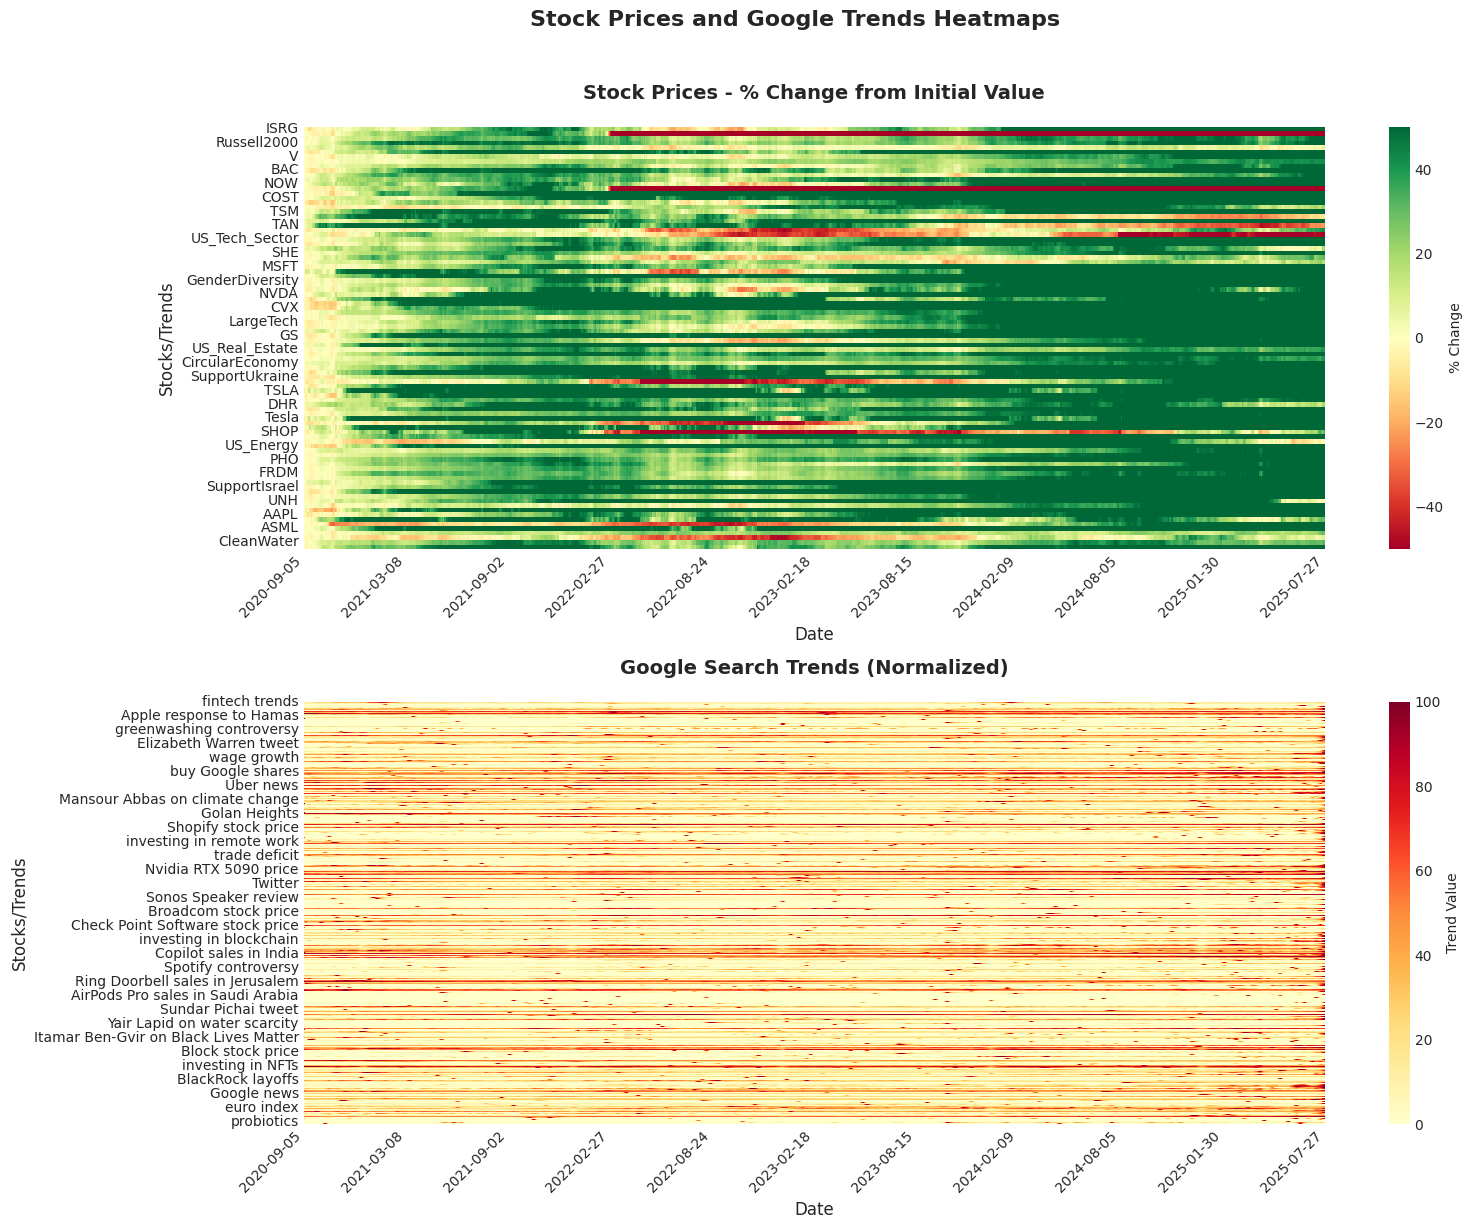

In [67]:
if df_prices is not None and df_trends is not None:
    # Create figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(16, 12))
    fig.suptitle('Stock Prices and Google Trends Heatmaps',
                fontsize=16, fontweight='bold', y=1.02)

    # Create prices heatmap
    print("Creating prices heatmap...")
    create_heatmap(df_prices_normalized,
                    'Stock Prices - % Change from Initial Value',
                    axes[0],
                    cmap='RdYlGn',
                    center=0,
                    vmin=-50,  # Adjust based on your data range
                    vmax=50,
                    cbar_label='% Change')

    # Create trends heatmap
    print("Creating trends heatmap...")
    create_heatmap(df_trends,
                'Google Search Trends (Normalized)',
                axes[1],
                cmap='YlOrRd',
                center=None,
                vmin=0,
                vmax=100,
                cbar_label='Trend Value')

    # Adjust layout
    plt.tight_layout()

    # Save the figure
    output_file = 'stock_trends_heatmap.png'
    plt.savefig((PLOT_ROOT / output_file), dpi=300, bbox_inches='tight')
    print(f"\nHeatmap saved as '{(PLOT_ROOT / output_file)}'")

    # Show the plot
    plt.show()
else:
    print("Error: Could not create heatmaps. Please check that both data files are loaded correctly.")

### Individual Heatmaps with Custom Settings

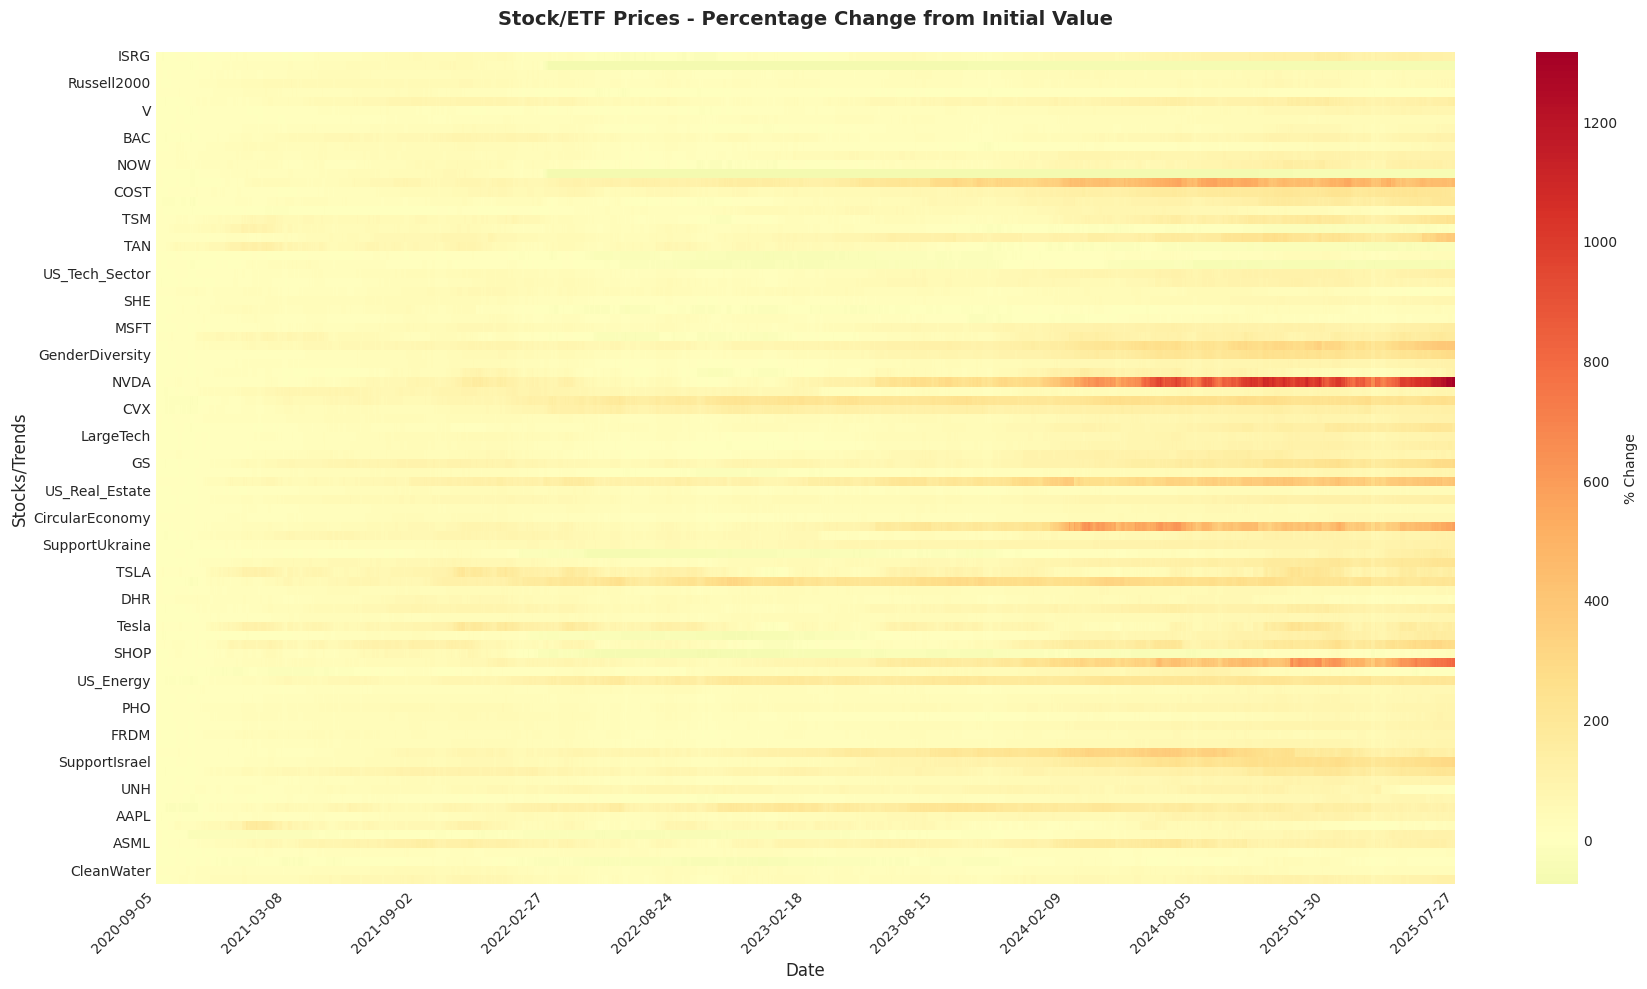

In [68]:
# Create a larger, more detailed prices heatmap
if df_prices_normalized is not None:
    fig, ax = plt.subplots(figsize=(18, 10))

    # You can customize the colormap here
    create_heatmap(df_prices_normalized,
                    'Stock/ETF Prices - Percentage Change from Initial Value',
                    ax,
                    cmap='RdYlGn_r',  # Try different colormaps: 'coolwarm', 'RdBu_r', 'seismic'
                    center=0,
                    vmin=df_prices_normalized.min().min(),
                    vmax=df_prices_normalized.max().max(),
                    cbar_label='% Change')

    plt.tight_layout()
    plt.savefig(PLOT_ROOT / 'detailed_prices_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

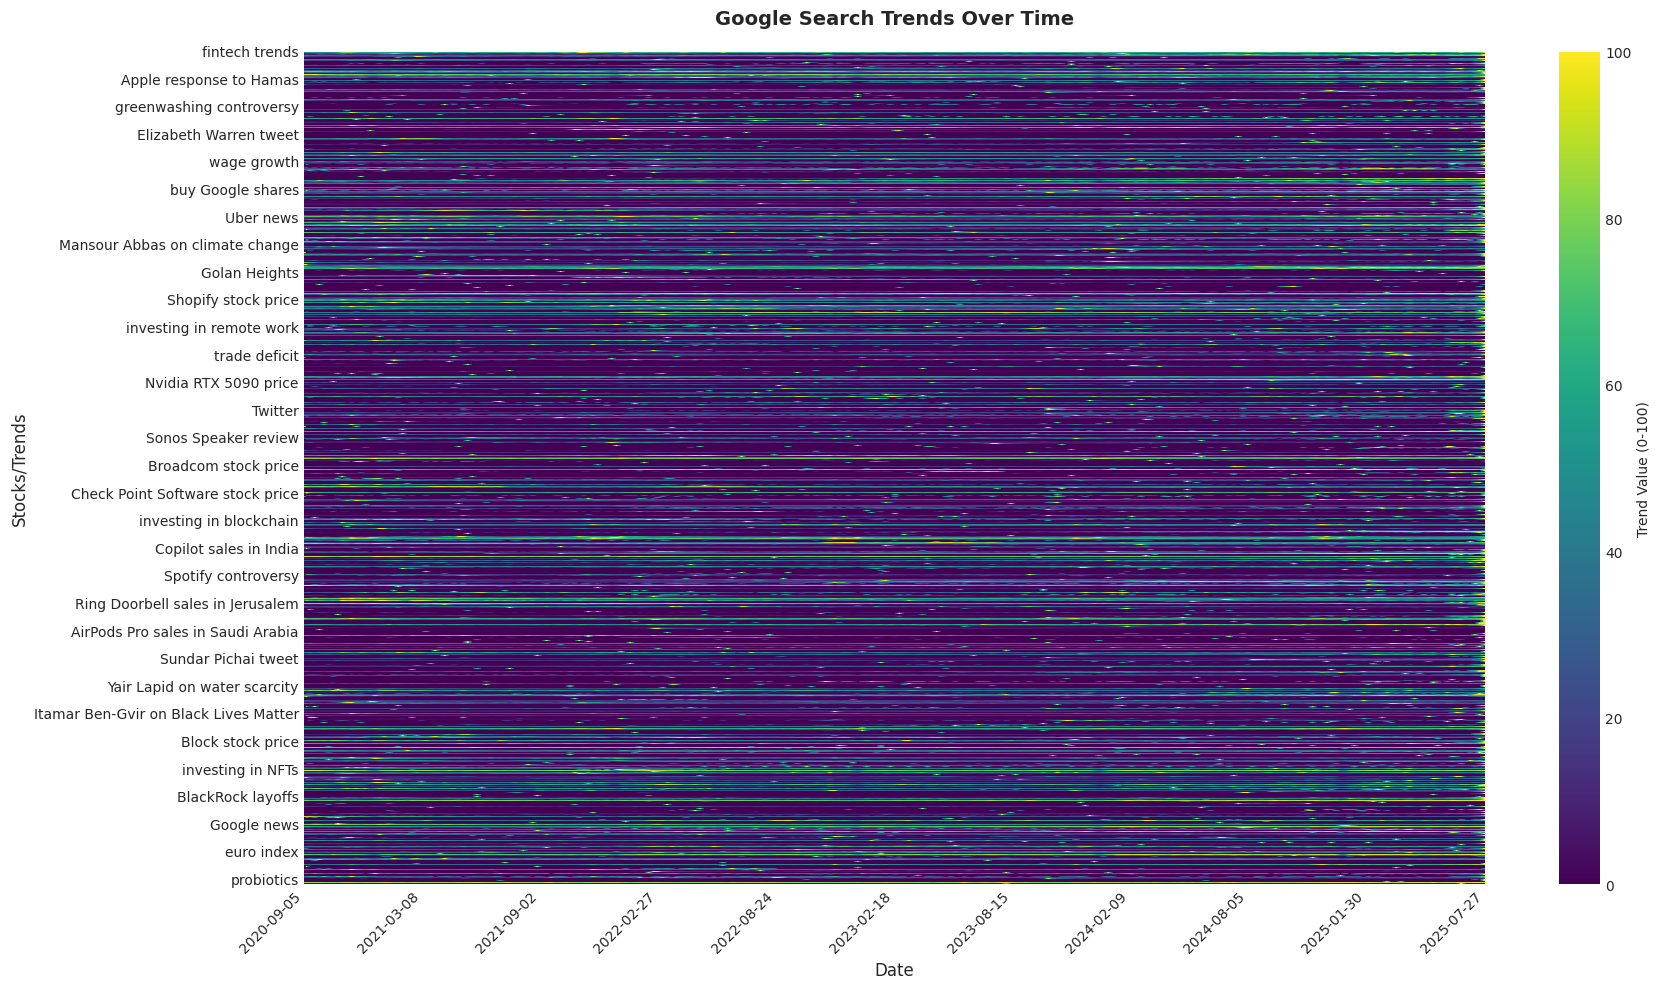

In [69]:
### # Create a larger, more detailed trends heatmap
if df_trends is not None:
    fig, ax = plt.subplots(figsize=(18, 10))

    # You can customize the colormap here
    create_heatmap(df_trends,
                    'Google Search Trends Over Time',
                    ax,
                    cmap='viridis',  # Try different colormaps: 'plasma', 'inferno', 'magma'
                    center=None,
                    vmin=0,
                    vmax=100,
                    cbar_label='Trend Value (0-100)')

    plt.tight_layout()
    plt.savefig(PLOT_ROOT / 'detailed_trends_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

### Correlation Analysis

In [87]:
def correlations(df_prices, df_trends, sample_size_prices, sample_size_trends, annotation_limit=400):
    common_dates = df_prices.index.intersection(df_trends.index)
    print(f"Found {len(common_dates)} common dates between datasets")
    if len(common_dates) > 0:
        print(f"   Date range: {common_dates[0]} to {common_dates[-1]}")
        # Sample correlation analysis (adjustable number of items)
        n_stocks = min(sample_size_prices, len(df_prices.columns))
        n_trends = min(sample_size_trends, len(df_trends.columns))
        print(f"\nAnalyzing correlations between top {n_stocks} stocks and top {n_trends} trends...")

        # --- Build the matrix ----------------------------------------------------
        prices_subset = df_prices.loc[common_dates, df_prices.columns[:n_stocks]]
        trends_subset = df_trends.loc[common_dates, df_trends.columns[:n_trends]]

        # Check for overlapping column names and rename if necessary
        overlapping = set(prices_subset.columns) & set(trends_subset.columns)
        if overlapping:
            print(f"Warning: Found {len(overlapping)} overlapping column names. Renaming trend columns...")
            # Rename overlapping trend columns
            trends_subset = trends_subset.rename(columns={col: f"trend_{col}" for col in overlapping})

        # Combine for correlation matrix
        combined_df = pd.concat([prices_subset, trends_subset], axis=1)
        correlation_matrix = combined_df.corr()

        print(f"Correlation matrix size: {correlation_matrix.shape[0]}x{correlation_matrix.shape[1]} ({correlation_matrix.size} values)")

        # Decide whether to show the numbers
        show_numbers = correlation_matrix.size <= annotation_limit

        # Create correlation heatmap
        fig, ax = plt.subplots(figsize=(14, 12))

        sns.heatmap(
            correlation_matrix,
            annot=show_numbers,
            fmt='.2f' if show_numbers else '',
            cmap='coolwarm',
            center=0,
            vmin=-1,
            vmax=1,
            ax=ax,
            cbar_kws={'label': 'Correlation'},
            annot_kws={'size': 8} if show_numbers else None
        )

        ax.set_title(f'Correlation Matrix: Top {n_stocks} Stocks vs Top {n_trends} Trends',
                    fontsize=14, fontweight='bold')

        plt.tight_layout()
        filename = f'correlation_matrix_{n_stocks}stocks_{n_trends}trends.png'
        plt.savefig(PLOT_ROOT / filename, dpi=300, bbox_inches='tight')
        print(f"Correlation matrix saved as '{PLOT_ROOT / filename}'")
        plt.show()

        # Find strongest correlations
        print("\nStrongest Correlations (excluding self-correlations):")
        print("-" * 50)

        # Get correlation values between stocks and trends only
        stock_cols = prices_subset.columns
        trend_cols = trends_subset.columns  # These are the renamed columns if there were overlaps

        print(f"Stock columns: {len(stock_cols)}")
        print(f"Trend columns: {len(trend_cols)}")
        print(f"Correlation matrix columns: {list(correlation_matrix.columns)[:5]}...")  # Show first 5

        correlations = []
        for stock in stock_cols:
            for trend in trend_cols:
                try:
                    # trend_cols already contains the renamed columns, so use them directly
                    corr_val = correlation_matrix.loc[stock, trend]

                    # This should now be a scalar, but let's be safe
                    if hasattr(corr_val, 'item'):
                        corr_val = corr_val.item()
                    elif hasattr(corr_val, 'iloc'):
                        print(f"Warning: Still got Series for {stock}-{trend}, taking first value")
                        corr_val = corr_val.iloc[0]

                    # Skip NaN values
                    if pd.notna(corr_val):
                        # Store the original trend name (remove 'trend_' prefix if it was added)
                        original_trend = trend.replace('trend_', '') if trend.startswith('trend_') else trend
                        correlations.append((stock, original_trend, float(corr_val)))

                except (KeyError, IndexError, ValueError) as e:
                    print(f"Error with {stock}-{trend}: {e}")
                    continue

        # Sort by absolute correlation value
        correlations.sort(key=lambda x: abs(x[2]), reverse=True)

        # Display top 10 correlations
        print("\nTop 10 Stock-Trend Correlations:")
        for i, (stock, trend, corr) in enumerate(correlations[:10], 1):
            print(f"{i:2}. {stock:15} ↔ {trend:15} : {corr:+.3f}")
    else:
        print("No overlapping dates found between the two datasets")

Found 1781 common dates between datasets
   Date range: 2020-09-05 00:00:00 to 2025-07-27 00:00:00

Analyzing correlations between top 92 stocks and top 1870 trends...
Correlation matrix size: 1962x1962 (3849444 values)
Correlation matrix saved as '../../plots/heatmaps/correlation_matrix_92stocks_1870trends.png'


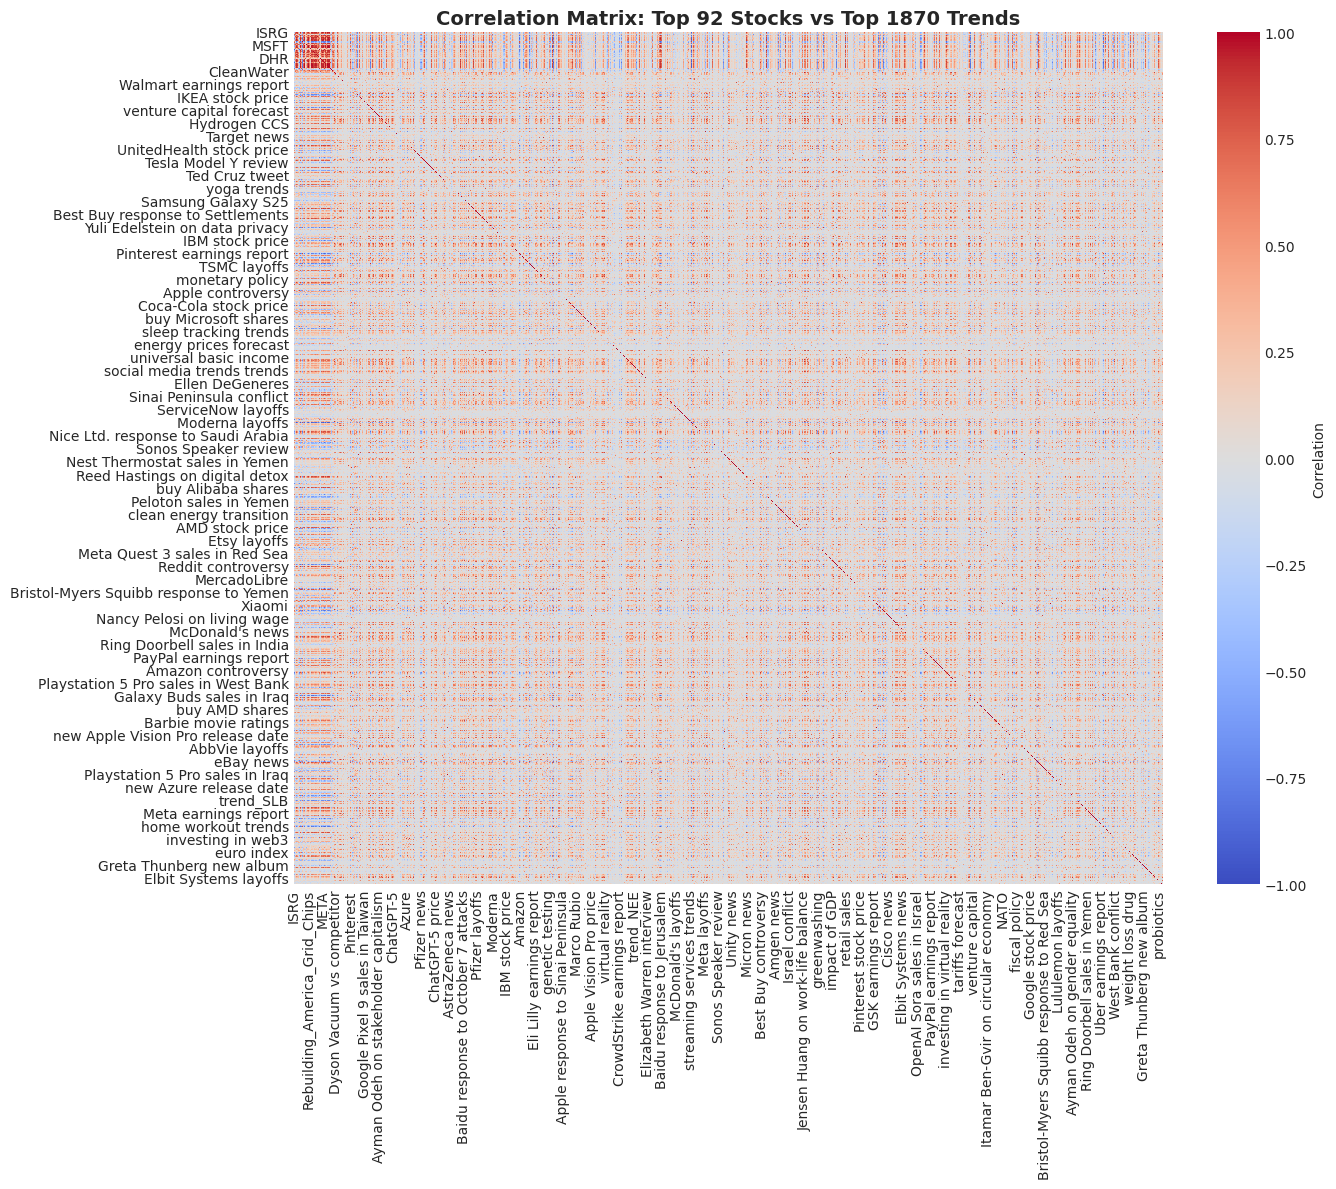


Strongest Correlations (excluding self-correlations):
--------------------------------------------------
Stock columns: 92
Trend columns: 1870
Correlation matrix columns: ['ISRG', 'RSX', 'US_Transportation', 'Russell2000', 'US_Biotech']...

Top 10 Stock-Trend Correlations:
 1. IBM             ↔ Copilot         : +0.970
 2. PANW            ↔ Reddit          : +0.960
 3. LLY             ↔ Reddit          : +0.958
 4. SAP             ↔ Copilot         : +0.957
 5. SupportUkraine  ↔ MercadoLibre    : -0.956
 6. V               ↔ Copilot         : +0.956
 7. MA              ↔ Copilot         : +0.955
 8. AVGO            ↔ Copilot         : +0.953
 9. BKNG            ↔ Copilot         : +0.949
10. COST            ↔ Reddit          : +0.947


In [88]:
# Find common dates between datasets
if df_prices is not None and df_trends is not None:
    correlations(df_prices, df_trends, sample_size_prices=10000, sample_size_trends=10000)

Found 1781 common dates between datasets
   Date range: 2020-09-05 00:00:00 to 2025-07-27 00:00:00

Analyzing correlations between top 92 stocks and top 100 trends...
Correlation matrix size: 192x192 (36864 values)
Correlation matrix saved as '../../plots/heatmaps/correlation_matrix_92stocks_100trends.png'


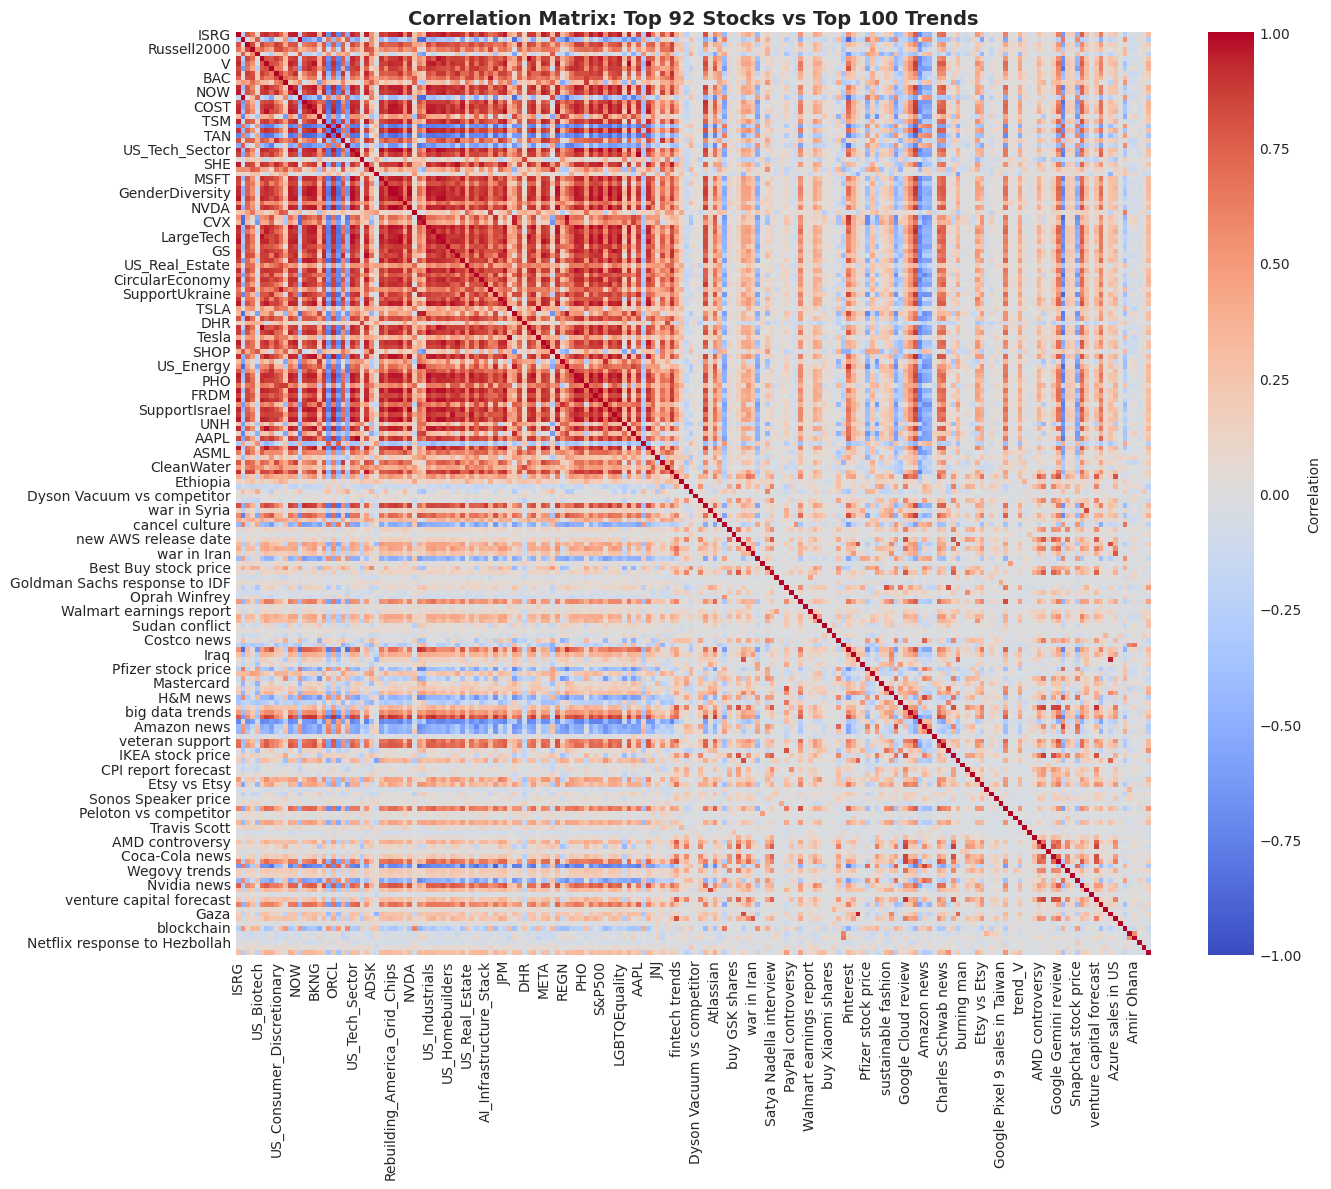


Strongest Correlations (excluding self-correlations):
--------------------------------------------------
Stock columns: 92
Trend columns: 100
Correlation matrix columns: ['ISRG', 'RSX', 'US_Transportation', 'Russell2000', 'US_Biotech']...

Top 10 Stock-Trend Correlations:
 1. IBM             ↔ cybersecurity   : +0.916
 2. AVGO            ↔ cybersecurity   : +0.911
 3. LLY             ↔ Eli Lilly stock price : +0.909
 4. PANW            ↔ cybersecurity   : +0.905
 5. XOM             ↔ Pinterest       : +0.904
 6. Rebuilding_America_Grid_Chips ↔ cybersecurity   : +0.903
 7. ORCL            ↔ cybersecurity   : +0.899
 8. SupportIsrael   ↔ Eli Lilly stock price : +0.898
 9. US_Energy       ↔ Pinterest       : +0.891
10. GenderDiversity ↔ Eli Lilly stock price : +0.890


In [89]:
# Find common dates between datasets
if df_prices is not None and df_trends is not None:
    correlations(df_prices, df_trends, sample_size_prices=100, sample_size_trends=100)


Found 1781 common dates between datasets
   Date range: 2020-09-05 00:00:00 to 2025-07-27 00:00:00

Analyzing correlations between top 50 stocks and top 50 trends...
Correlation matrix size: 100x100 (10000 values)
Correlation matrix saved as '../../plots/heatmaps/correlation_matrix_50stocks_50trends.png'


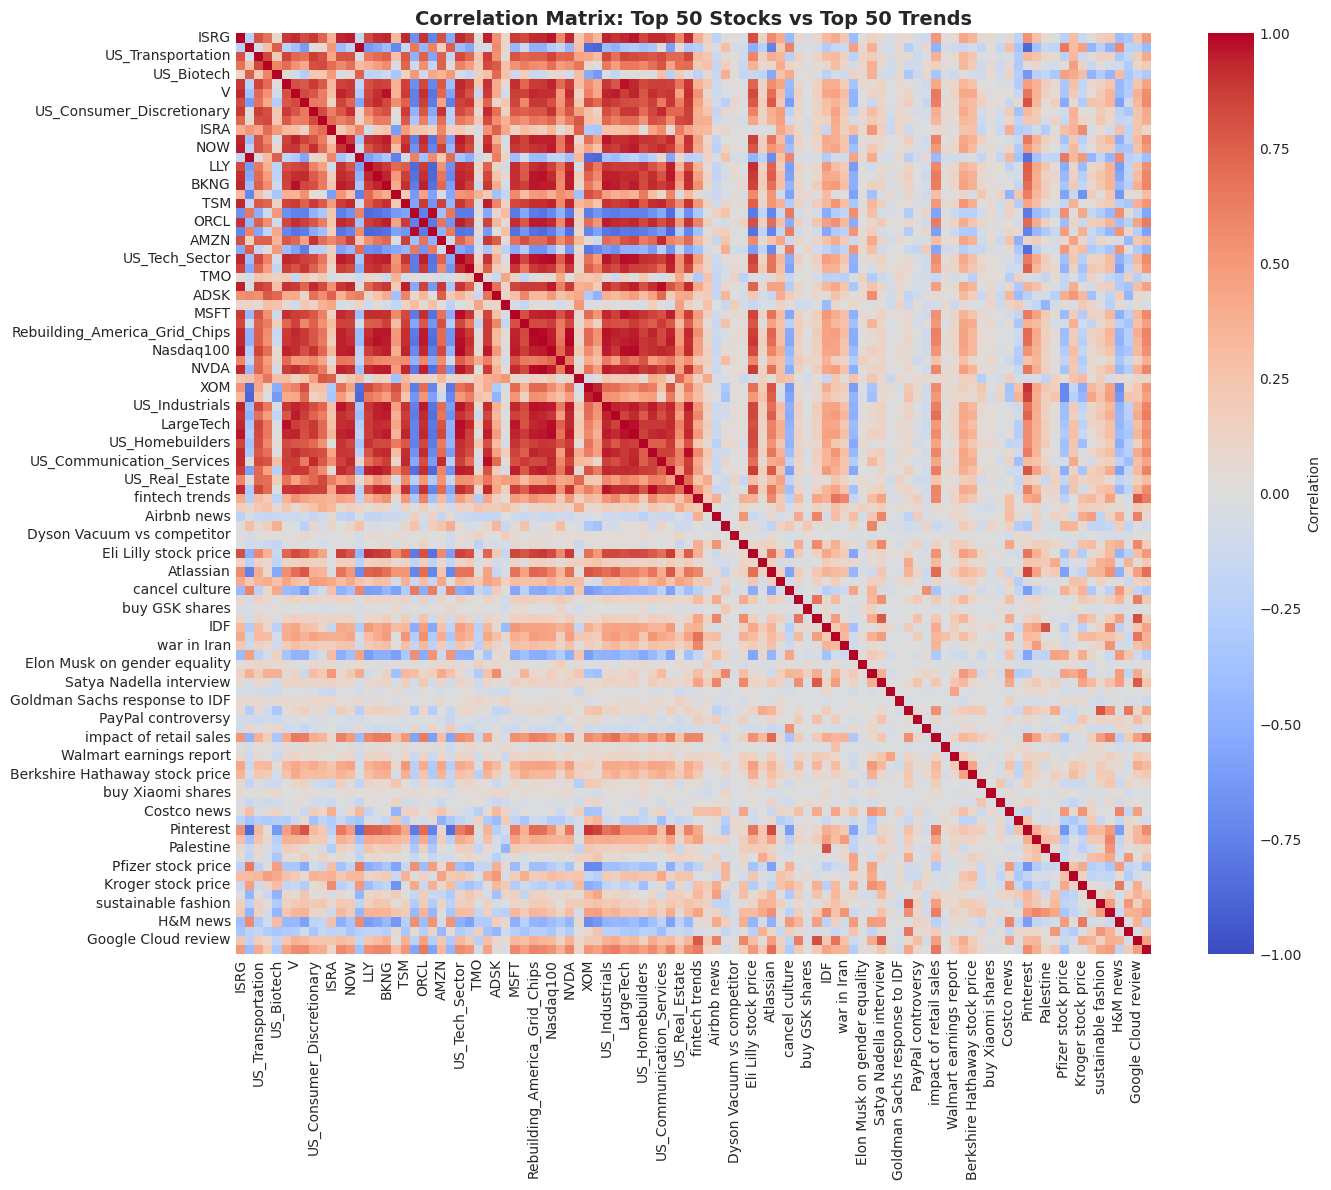


Strongest Correlations (excluding self-correlations):
--------------------------------------------------
Stock columns: 50
Trend columns: 50
Correlation matrix columns: ['ISRG', 'RSX', 'US_Transportation', 'Russell2000', 'US_Biotech']...

Top 10 Stock-Trend Correlations:
 1. LLY             ↔ Eli Lilly stock price : +0.909
 2. XOM             ↔ Pinterest       : +0.904
 3. GenderDiversity ↔ Eli Lilly stock price : +0.890
 4. NVDA            ↔ Eli Lilly stock price : +0.882
 5. COST            ↔ Eli Lilly stock price : +0.878
 6. PANW            ↔ Eli Lilly stock price : +0.875
 7. RSX             ↔ Pinterest       : -0.865
 8. Rebuilding_America_Grid_Chips ↔ Eli Lilly stock price : +0.865
 9. SYK             ↔ Eli Lilly stock price : +0.860
10. US_Tech_Sector  ↔ Eli Lilly stock price : +0.859


In [90]:
if df_prices is not None and df_trends is not None:
    correlations(df_prices, df_trends, sample_size_prices=50, sample_size_trends=50)

Found 1781 common dates between datasets
   Date range: 2020-09-05 00:00:00 to 2025-07-27 00:00:00

Analyzing correlations between top 10 stocks and top 10 trends...
Correlation matrix size: 20x20 (400 values)
Correlation matrix saved as '../../plots/heatmaps/correlation_matrix_10stocks_10trends.png'


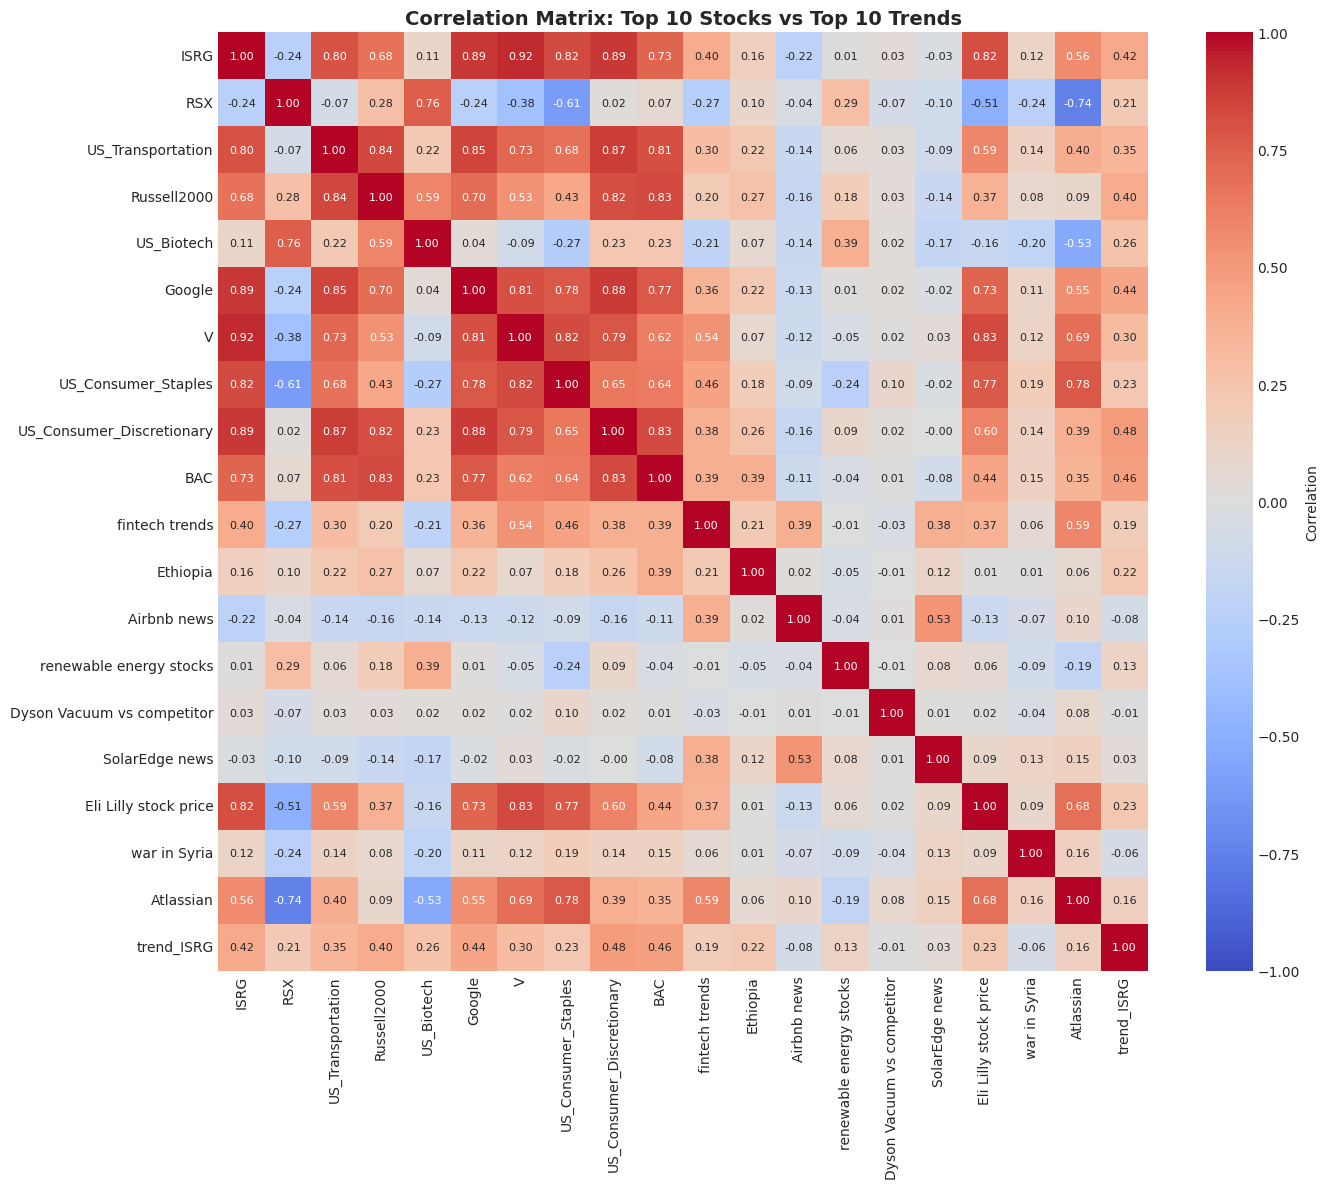


Strongest Correlations (excluding self-correlations):
--------------------------------------------------
Stock columns: 10
Trend columns: 10
Correlation matrix columns: ['ISRG', 'RSX', 'US_Transportation', 'Russell2000', 'US_Biotech']...

Top 10 Stock-Trend Correlations:
 1. V               ↔ Eli Lilly stock price : +0.832
 2. ISRG            ↔ Eli Lilly stock price : +0.819
 3. US_Consumer_Staples ↔ Atlassian       : +0.776
 4. US_Consumer_Staples ↔ Eli Lilly stock price : +0.766
 5. RSX             ↔ Atlassian       : -0.743
 6. Google          ↔ Eli Lilly stock price : +0.734
 7. V               ↔ Atlassian       : +0.691
 8. US_Consumer_Discretionary ↔ Eli Lilly stock price : +0.602
 9. US_Transportation ↔ Eli Lilly stock price : +0.591
10. ISRG            ↔ Atlassian       : +0.563


In [91]:
if df_prices is not None and df_trends is not None:
    correlations(df_prices, df_trends, sample_size_prices=10, sample_size_trends=10)

### Time Series Analysis

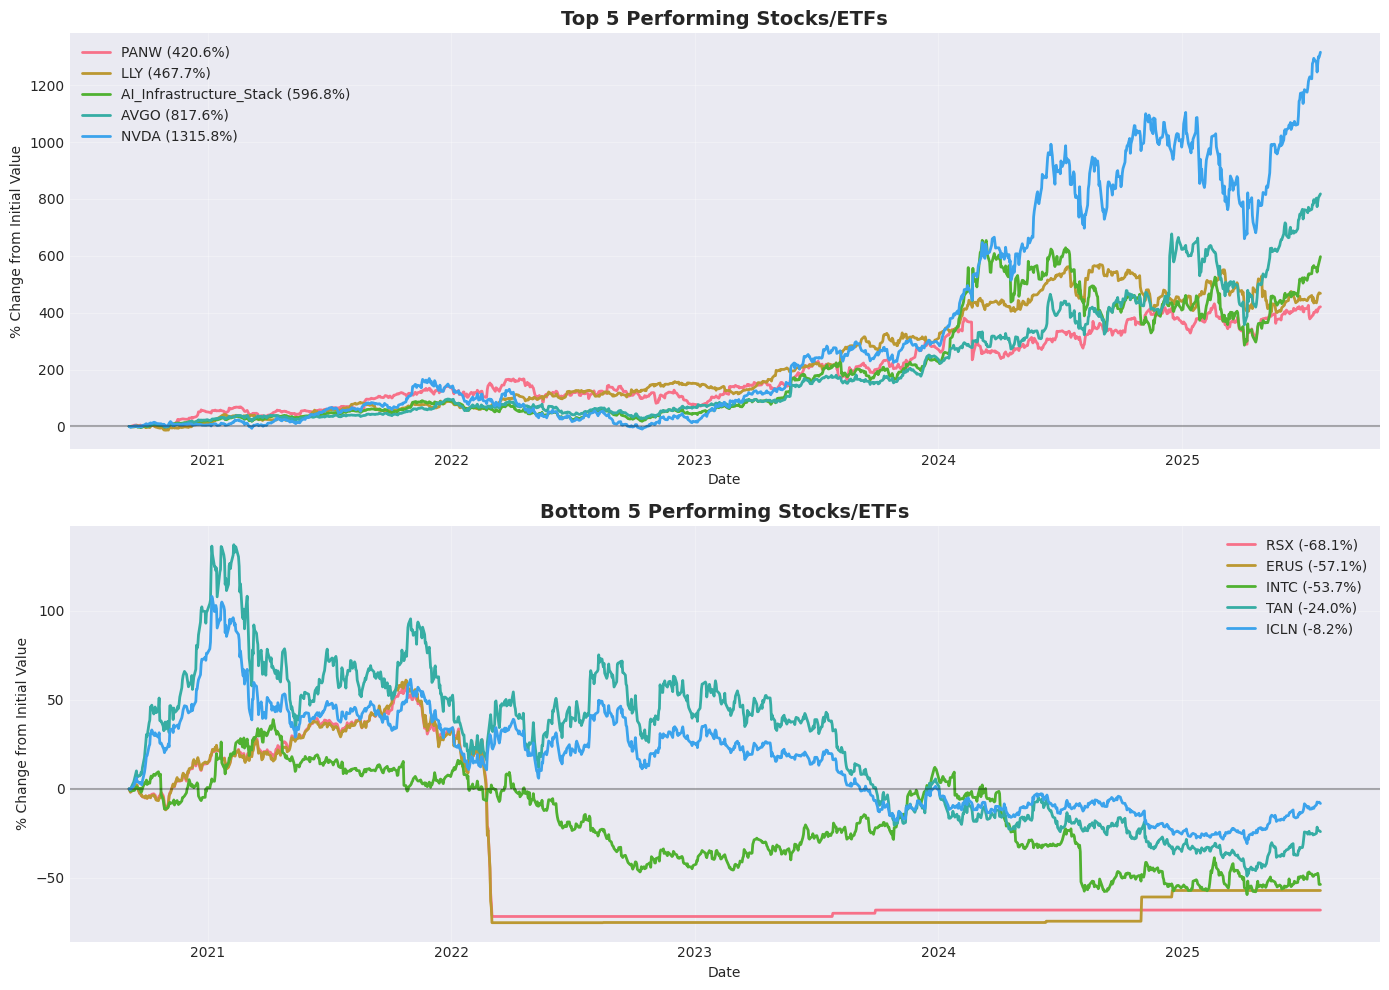

In [92]:
# Plot top performing stocks and most popular trends
if df_prices_normalized is not None:
    # Find top gainers and losers
    final_changes = df_prices_normalized.iloc[-1].sort_values()
    top_gainers = final_changes.tail(5).index
    top_losers = final_changes.head(5).index

    # Create subplots
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))

    # Plot top gainers
    for stock in top_gainers:
        axes[0].plot(df_prices_normalized.index, df_prices_normalized[stock],
                    label=f"{stock} ({final_changes[stock]:.1f}%)", linewidth=2)

    axes[0].set_title('Top 5 Performing Stocks/ETFs', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('% Change from Initial Value')
    axes[0].legend(loc='best')
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(y=0, color='black', linestyle='-', alpha=0.3)

    # Plot top losers
    for stock in top_losers:
        axes[1].plot(df_prices_normalized.index, df_prices_normalized[stock],
                    label=f"{stock} ({final_changes[stock]:.1f}%)", linewidth=2)

    axes[1].set_title('Bottom 5 Performing Stocks/ETFs', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('% Change from Initial Value')
    axes[1].legend(loc='best')
    axes[1].grid(True, alpha=0.3)
    axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)

    plt.tight_layout()
    plt.savefig(PLOT_ROOT / 'top_bottom_performers.png', dpi=300, bbox_inches='tight')
    plt.show()

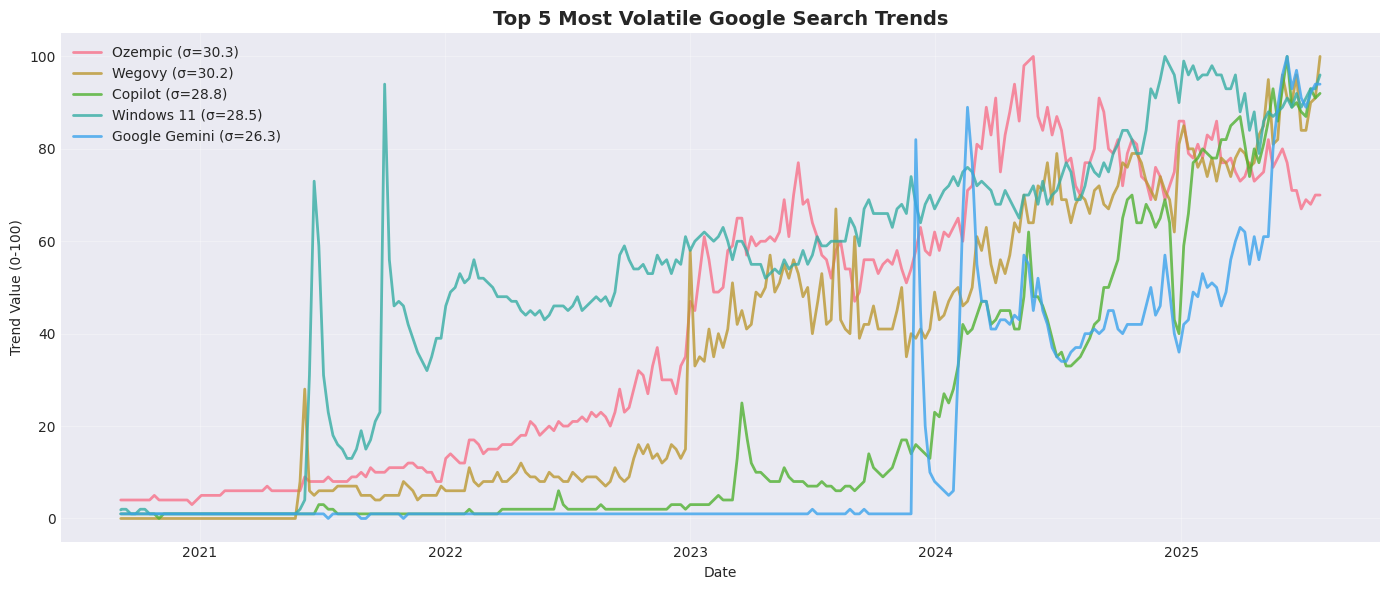

In [93]:
# Plot most volatile trends
if df_trends is not None:
    # Calculate volatility (standard deviation) for each trend
    trend_volatility = df_trends.std().sort_values(ascending=False)
    most_volatile = trend_volatility.head(5).index

    # Create plot
    fig, ax = plt.subplots(figsize=(14, 6))

    for trend in most_volatile:
        ax.plot(df_trends.index, df_trends[trend],
                label=f"{trend} (σ={trend_volatility[trend]:.1f})",
                linewidth=2, alpha=0.8)

    ax.set_title('Top 5 Most Volatile Google Search Trends', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Trend Value (0-100)')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(PLOT_ROOT / 'volatile_trends.png', dpi=300, bbox_inches='tight')
    plt.show()

### Summary Statistics

In [94]:
print("=" * 60)
print("ANALYSIS SUMMARY")
print("=" * 60)

if df_prices_normalized is not None:
    print("\nSTOCK/ETF PERFORMANCE:")
    print("-" * 40)

    final_changes = df_prices_normalized.iloc[-1].sort_values()

    print(f"Total stocks/ETFs analyzed: {len(df_prices.columns)}")
    print(f"Date range: {df_prices.index[0].strftime('%Y-%m-%d')} to {df_prices.index[-1].strftime('%Y-%m-%d')}")
    print(f"Number of trading days: {len(df_prices.index)}")

    print(f"\nPerformance Overview:")
    print(f"\t* Best performer: {final_changes.index[-1]} ({final_changes.iloc[-1]:.2f}%)")
    print(f"\t* Worst performer: {final_changes.index[0]} ({final_changes.iloc[0]:.2f}%)")
    print(f"\t* Average change: {final_changes.mean():.2f}%")
    print(f"\t* Median change: {final_changes.median():.2f}%")
    print(f"\t* Positive performers: {(final_changes > 0).sum()} ({(final_changes > 0).sum()/len(final_changes)*100:.1f}%)")
    print(f"\t* Negative performers: {(final_changes < 0).sum()} ({(final_changes < 0).sum()/len(final_changes)*100:.1f}%)")

if df_trends is not None:
    print("\nGOOGLE TRENDS:")
    print("-" * 40)

    print(f"Total search terms analyzed: {len(df_trends.columns)}")
    print(f"Date range: {df_trends.index[0].strftime('%Y-%m-%d')} to {df_trends.index[-1].strftime('%Y-%m-%d')}")
    print(f"Number of days: {len(df_trends.index)}")

    avg_trends = df_trends.mean().sort_values(ascending=False)

    print(f"\nTrend Popularity (Average):")
    print(f"\t* Most popular: {avg_trends.index[0]} ({avg_trends.iloc[0]:.1f})")
    print(f"\t* Least popular: {avg_trends.index[-1]} ({avg_trends.iloc[-1]:.1f})")
    print(f"\t* Average trend value: {avg_trends.mean():.1f}")

    trend_volatility = df_trends.std().sort_values(ascending=False)
    print(f"\nTrend Volatility:")
    print(f"\t* Most volatile: {trend_volatility.index[0]} (σ={trend_volatility.iloc[0]:.1f})")
    print(f"\t* Most stable: {trend_volatility.index[-1]} (σ={trend_volatility.iloc[-1]:.1f})")

print("\n" + "=" * 60)
print("Analysis complete! All visualizations have been saved.")
print("=" * 60)

ANALYSIS SUMMARY

STOCK/ETF PERFORMANCE:
----------------------------------------
Total stocks/ETFs analyzed: 92
Date range: 2020-09-05 to 2025-07-27
Number of trading days: 1781

Performance Overview:
	* Best performer: NVDA (1315.76%)
	* Worst performer: RSX (-68.11%)
	* Average change: 139.85%
	* Median change: 102.70%
	* Positive performers: 85 (92.4%)
	* Negative performers: 7 (7.6%)

GOOGLE TRENDS:
----------------------------------------
Total search terms analyzed: 1870
Date range: 2020-09-05 to 2025-07-27
Number of days: 1781

Trend Popularity (Average):
	* Most popular: MA (85.9)
	* Least popular: ChatGPT-5 price (0.3)
	* Average trend value: 14.4

Trend Volatility:
	* Most volatile: Ozempic (σ=30.3)
	* Most stable: Ellen DeGeneres (σ=3.7)

Analysis complete! All visualizations have been saved.


### Export Processed Data

In [95]:
if df_prices_normalized is not None:
    df_prices_normalized.to_csv(PROCESSED_DATA / 'prices_normalized.csv')
    print("Normalized prices saved to 'prices_normalized.csv'")

if 'correlation_matrix' in locals():
    correlation_matrix.to_csv(PLOT_ROOT / 'correlation_matrix.csv')
    print("Correlation matrix saved to 'correlation_matrix.csv'")

Normalized prices saved to 'prices_normalized.csv'
Correlation matrix saved to 'correlation_matrix.csv'


### Possible Next Steps
#### 1. **Clustering Analysis**: Group stocks with similar performance patterns
#### 2. **Lead-Lag Analysis**: Investigate if certain trends predict stock movements
#### 3. **Seasonal Patterns**: Analyze monthly or quarterly patterns in both datasets
#### 4. **Anomaly Detection**: Identify unusual spikes or drops in prices/trends
#### 5. **Rolling Correlations**: See how correlations change over time
#### 6. **Sector Analysis**: Group stocks by sector and compare sector performance